### Análisis exploratorio de datos

Esta notebook esta dedicada a explorar el set de datos y asi poder extraer conocimiento, siguientes pasos y consideraciones en la evaluación del mismo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
import nltk
import spacy
import re
%matplotlib inline

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, size, split, count, when, udf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mode

In [3]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angelmata/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from nltk.corpus import stopwords

In [5]:
df = pd.read_csv('../data/apli_challenge_data.csv')
print("Primeras filas del dataset:")
df.head()

Primeras filas del dataset:


,news_id,news_body,news_header
0,0,dos semanas después de su puesta de largo y pr...,el submarino s-80 ya flota
1,1,"este viernes, el presidente del gobierno, pedr...",calviño y calvo alaban (sin darse cuenta) la g...
2,2,"el ministro del interior, fernando grande-marl...",el geo de la policía tendrá una nueva sede en ...
3,3,son días muy duros para la familia de olivia y...,"la madre de las niñas ""sobran las palabras par..."
4,4,sólo quedan 10 presos de eta por recibir los b...,sólo quedan 10 presos de eta por recibir el be...


- Información del dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58424 entries, 0 to 58423
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   news_id      58424 non-null  int64 
 1   news_body    58424 non-null  object
 2   news_header  58424 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


Revisaremos los valores nulos y duplicados en el dataset 

In [7]:
num_body_duplicates = df.duplicated(subset=['news_body']).sum()
print(f"Número de registros duplicados en la columna 'news_body': {num_body_duplicates}")

# Duplicados considerando solo la columna "news_header"
num_header_duplicates = df.duplicated(subset=['news_header']).sum()
print(f"Número de registros duplicados en la columna 'news_header': {num_header_duplicates}")


# Duplicados considerando ambas columnas "news_body" y "news_header"
num_body_header_duplicates = df.duplicated(subset=['news_body', 'news_header']).sum()
print(f"Número de registros duplicados basados en 'news_body' y 'news_header': {num_body_header_duplicates}")


Número de registros duplicados en la columna 'news_body': 14956
Número de registros duplicados en la columna 'news_header': 15019
Número de registros duplicados basados en 'news_body' y 'news_header': 14953


Observamos que hay una gran cantidad de datos duplicados, ahora evaluaremos que en verdad sean replicas exactas y no se trate de noticias con pequeñas variaciones, de ser duplicados exactos tomaremos la decision de eliminar, ya que la presencia de duplicados puedo sesgar las estadisticas y afectar el entrenamientos del modelo, ya uqe ciertas noticias tendran una mayor precensia frente a las demas.

In [8]:
duplicates = df[df.duplicated(subset=['news_body', 'news_header'])].copy()
duplicates.head(10)

,news_id,news_body,news_header
21,21,el ministerio español de ciencia e innovación ...,las diez vacunas contra la covid made in spain»
22,22,los prejuicios son la mayor barrera de las per...,suspenso en inclusión de trabajadores con disc...
23,23,"a la expectativa, resolviendo a toda prisa y s...",nueve millones de españoles podrían seguir baj...
33,33,el ministerio español de ciencia e innovación ...,las diez vacunas contra la covid made in spain»
34,34,los prejuicios son la mayor barrera de las per...,suspenso en inclusión de trabajadores con disc...
35,35,"a la expectativa, resolviendo a toda prisa y s...",nueve millones de españoles podrían seguir baj...
45,45,el ministerio español de ciencia e innovación ...,las diez vacunas contra la covid made in spain»
46,46,los prejuicios son la mayor barrera de las per...,suspenso en inclusión de trabajadores con disc...
47,47,"a la expectativa, resolviendo a toda prisa y s...",nueve millones de españoles podrían seguir baj...
57,57,el ministerio español de ciencia e innovación ...,las diez vacunas contra la covid made in spain»


Realizaremos una inspección de 3 ejemplos para revisar que el contenido de sus noticias sea exactamente igual

In [9]:
def check_duplicates(df, id1, id2):
    news_body_id1 = df.loc[df["news_id"] == id1, "news_body"].values[0]
    news_body_id2 = df.loc[df["news_id"] == id2, "news_body"].values[0]

    news_header_id1 = df.loc[df["news_id"] == id1, "news_header"].values[0]
    news_header_id2 = df.loc[df["news_id"] == id2, "news_header"].values[0]
    
    return news_body_id1 == news_body_id2 and news_header_id1 == news_header_id2

In [10]:
duplicate_ids = [[21,33],[22,34],[23,35]]
for id1, id2 in duplicate_ids:
    print(f"\n\nComparando los registros con news_id {id1} y {id2}")
    if check_duplicates(df, id1, id2):
        print("Los registros son iguales")
    else:
        print("Los registros son diferentes")



Comparando los registros con news_id 21 y 33
Los registros son iguales


Comparando los registros con news_id 22 y 34
Los registros son iguales


Comparando los registros con news_id 23 y 35
Los registros son iguales


Con esta pequeña muestra confirmamos que se tamaron los registros exactamente iguales, con el fin de no sesgar el modelo seran eliminados, otra alternativa un poco más laboriosa seria ocupar tecnicas de deduplicacion fuzzy, sin embargo haremos el eliminado.

In [11]:
df = df.drop_duplicates(subset=['news_body', 'news_header'], keep='first')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43471 entries, 0 to 58423
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   news_id             43471 non-null  int64 
 1   news_body           43471 non-null  object
 2   news_header         43471 non-null  object
 3   news_body_length    43471 non-null  int64 
 4   news_header_length  43471 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.0+ MB


- Revisamos valores nulos

In [12]:
print("\nValores nulos por columna:")
df.isnull().sum()


Valores nulos por columna:


news_id        0
news_body      0
news_header    0
dtype: int64

- Creamos nuevas columnas para la cantidad de palabras en news_body y news_header

In [13]:
df['news_body_length'] = df['news_body'].apply(lambda x: len(str(x).split()))
df['news_header_length'] = df['news_header'].apply(lambda x: len(str(x).split()))

Ahora generamos las estadísticas descriptivas de la longitud de los textos con el fin de averiguar posibles relaciones entre ellos 

In [14]:
df[['news_body_length', 'news_header_length']].describe()

,news_body_length,news_header_length
count,43471.000000,43471.000000
mean,611.853489,14.030595
std,461.033015,4.168719
min,2.000000,1.000000
25%,346.000000,11.000000
50%,513.000000,14.000000
75%,750.000000,17.000000
max,15348.000000,36.000000


Identificamos que pueden existirs valores atipicos en la longitud de ambos columnas (news_body y news_header), dado que:
-   news_body_length: 
      -   Media: 710.31
      -   Max: 15348.00
-   news_header_length
      -   Media: 13.29
      -   Max: 36.00

- Creamos una función para generar visualizaciones de las longitudes de las noticias y de los resumenes, con el fin de identificar posibles valores atipicos y anomalias dentro del dataset

In [15]:
def plot_all_features(df, columns):
    fig = plt.figure(figsize=(15, 6))
    rows, cols = 1, 2
    for i in range(1, rows * cols + 1):
        col = columns[i - 1]
        fig.add_subplot(rows, cols, i)
        sns.histplot(df[col], bins=10, kde=True, color='skyblue')
        plt.title(f'Distribucion de Media, Mediana y Moda para {col}')
        plt.xlabel('Valores')
        plt.ylabel('Frecuencia')
        counts, bin_edges = np.histogram(df[col], bins=10)
        bin_edges = np.round(bin_edges, 2)
        col_mean = np.mean(df[col])
        col_median = np.median(df[col])
        col_mode = mode(df[col])[0]
        plt.axvline(col_mean, color='red', linestyle='dashed', linewidth=2, label=f'Media: {col_mean:.2f}')
        plt.axvline(col_median, color='green', linestyle='dashed', linewidth=2, label=f'Mediana: {col_median:.2f}')
        plt.axvline(col_mode, color='orange', linestyle='dashed', linewidth=2, label=f'Moda: {col_mode:.2f}')
        plt.xticks(bin_edges)
        plt.legend()

    plt.subplots_adjust(hspace=0.5)

    plt.show()

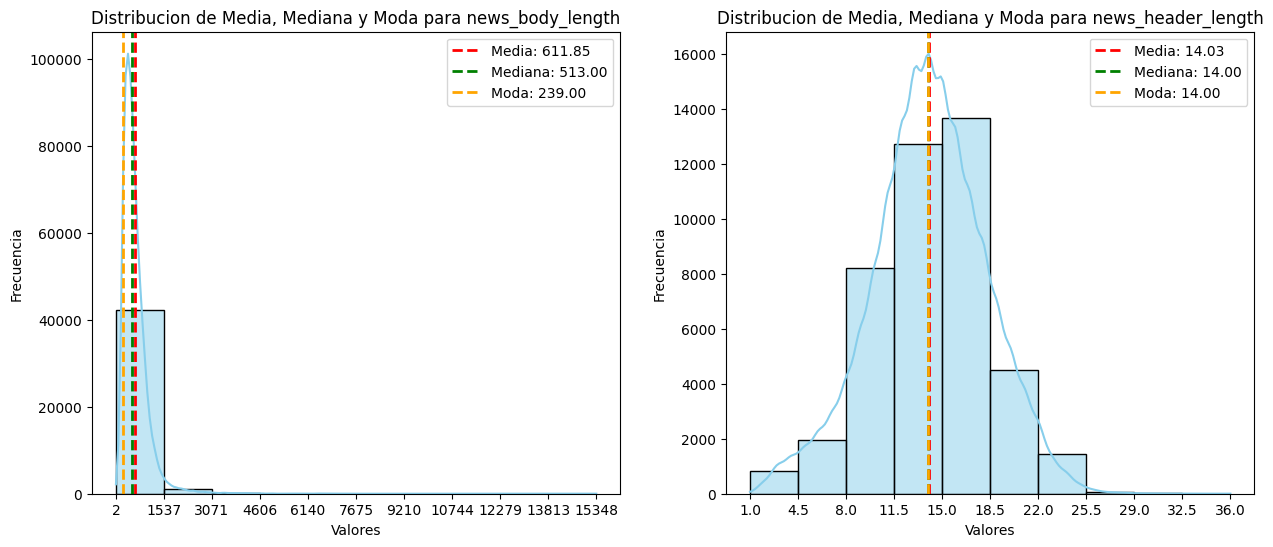

In [16]:
plot_all_features(df, ['news_body_length', 'news_header_length'])

Dadas estas visualizaciones de las distribuciones de las longitudes de las noticias y su correspondiente encabezado, observamos los siguiente:
-   La longitud de las noticias presenta una distribucion sesgada hacia la derecha
-   Podemos observar que las noticias (evidentemente) tienen una longitud más grande que los encabezados

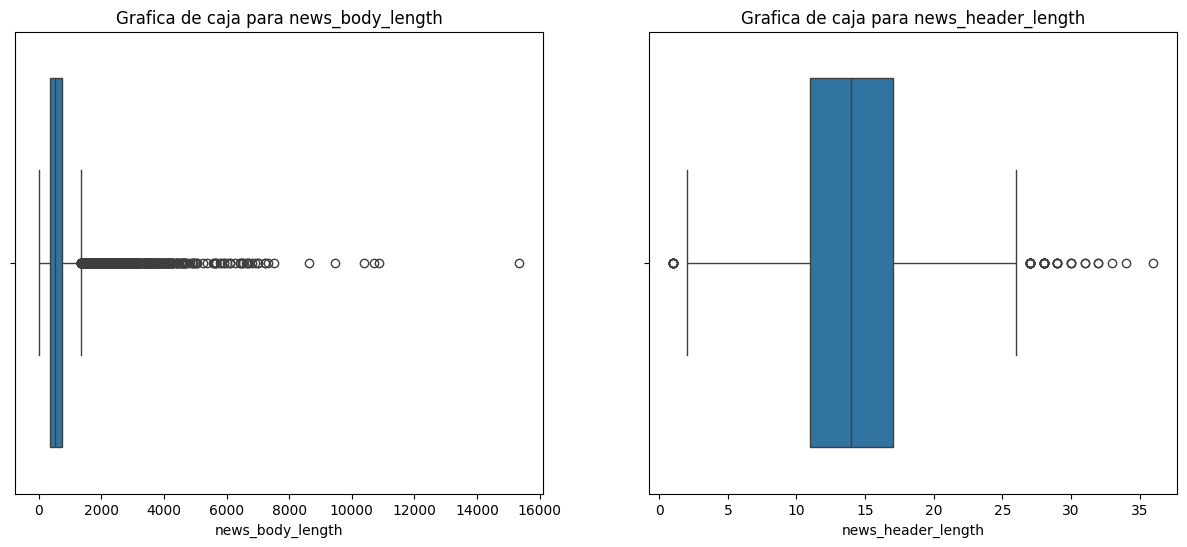

In [17]:
rows, cols = 1,2
columns = ['news_body_length', 'news_header_length']
fig = plt.figure(figsize=(15,6))

for i, col in enumerate(columns):
  fig.add_subplot(rows, cols, i+1)
  sns.boxplot(data=df[col], orient='h')
  plt.title(f"Grafica de caja para {col}")

plt.subplots_adjust(hspace=0.5)
plt.show()

Dada la presencia de valores atipicos en las noticias, se tendra en cuenta a la hora de la evaluación del modelo, siendo más preciso tendremos especial atención para ver si tiene alguna inclinacion hacia algun resultado en especifico.

Tambien consideraremos la opcion de borrar estos valores atipicos y si tendremos alguna repercución en el modelo, se impondra un limite de 5000 palabras y su relacion con la longitud de su encabezado.

In [18]:
threshold = 5000
outliers = df[(df['news_body_length'] >= threshold)]
print(f"\n===== Número de valores atípicos detectados (news_body_length > {threshold}): {len(outliers)} =====")
print(f"\n===== Porcentaje de datos que son canditatos a borrar {((len(outliers)/len(df)) * 100): 0.2f}% =====")



===== Número de valores atípicos detectados (news_body_length > 5000): 41 =====

===== Porcentaje de datos que son canditatos a borrar  0.09% =====


Revisaremos la relacion entre la longitud de las noticias y la longitud de los resumenes:
- Si vemos que existe una relacion entre la longitud de la noticia y la longitud del resumen, entonces consideramos la coherencia que tiene el dataset

In [19]:
df[['news_body_length', 'news_header_length']].corr()

,news_body_length,news_header_length
news_body_length,1.00000,0.01795
news_header_length,0.01795,1.00000


Podemos concluir que no existe una relacion lineal significativa entre la longitud del cuerpo de la noticia y la longitud del encabezado (el valor de correlación es aproximadamente 0.01, muy cercano a 0).

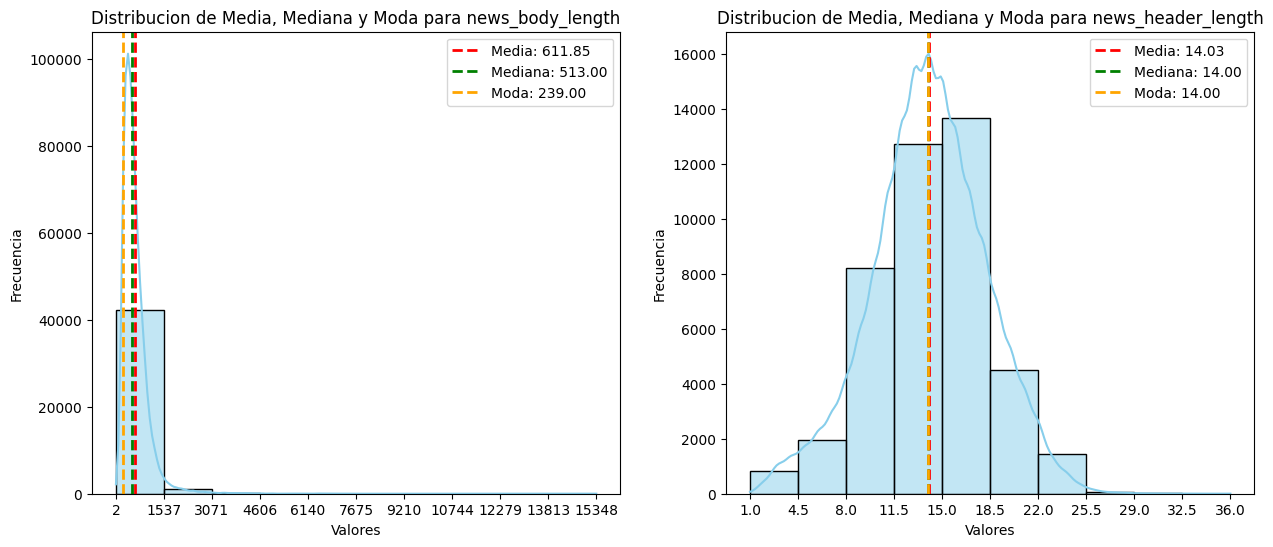

In [20]:
plot_all_features(df, ['news_body_length', 'news_header_length'])

#### Ahora comenzaremos un analisis acerca del contenido de las noticias y del encabezado

Extraemos una lista de palabras que pueden ser bloqueantes a la hora ver la relación entre las palabras que hay en el cuerpo de las noticias y las de la columna resultante, esto con el fin de revisar que las noticias y sus resumenes sean congruentes entre ellas.

In [3]:
# Descoomentar para instalar el paquete de spacy
#nltk.download('stopwords')

In [4]:
spanish_stopwords = stopwords.words('spanish')

NameError: name 'stopwords' is not defined

Ahora crearemos la funcion para ver las palabras que más se repiten en ambas columnas con ayuda del modelo CountVectorizer de scikit-learn

In [ ]:
def compute_unigram_frequencies(text_series):
    vectorizer = CountVectorizer(stop_words=spanish_stopwords)
    X = vectorizer.fit_transform(text_series)
    
    # Sum occurrences without converting to dense format
    word_freq = pd.Series(X.sum(axis=0).A1, index=vectorizer.get_feature_names_out())
    
    return word_freq.sort_values(ascending=False)

Despues esta función que nos ayudara a observar las dos palabras unidas frecuentes en relación al cuerpo de la noticia y del resumen

In [ ]:
def compute_bigram_frequencies(text_series):
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=spanish_stopwords)
    X = vectorizer.fit_transform(text_series)

    # Sum occurrences without converting to dense format
    bigram_freq = pd.Series(X.sum(axis=0).A1, index=vectorizer.get_feature_names_out())
    
    return bigram_freq.sort_values(ascending=False)

Definimos la función que nos ayudara a visualizar las palabras y su frecuencia en las colunmas 

In [ ]:
def plot_ngrams(data, columns, label):
    fig = plt.figure(figsize=(15, 6))
    rows, cols = 1, 2
    for i in range(1, rows * cols + 1):
      col = columns[i - 1]
      fig.add_subplot(rows, cols, i)
      sns.barplot(x=data[i-1].head(20).values, y=data[i-1].head(20).index, orient='h', palette='pastel')
      plt.title(f'Top 20 {label} Frequency for {col}')
      plt.xlabel('Frequency')
      plt.ylabel(label)
      plt.xticks(rotation=90)
      fig.tight_layout()

    plt.show()

Calculamos las palabras que más se repiten (unigrams), al igual que las dos palabras que más se repiten (bigrams)

In [ ]:
unigram_freq_c = compute_unigram_frequencies(df["news_body"])
unigram_freq_r = compute_unigram_frequencies(df["news_header"])

bigram_freq_c = compute_bigram_frequencies(df["news_body"])
bigram_freq_r = compute_bigram_frequencies(df["news_header"])

/var/folders/ny/ynfjr6_16n5bnkj_51l0bkjr0000gn/T/ipykernel_39331/2638156123.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[i-1].head(20).values, y=data[i-1].head(20).index, orient='h', palette='pastel')
/var/folders/ny/ynfjr6_16n5bnkj_51l0bkjr0000gn/T/ipykernel_39331/2638156123.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[i-1].head(20).values, y=data[i-1].head(20).index, orient='h', palette='pastel')


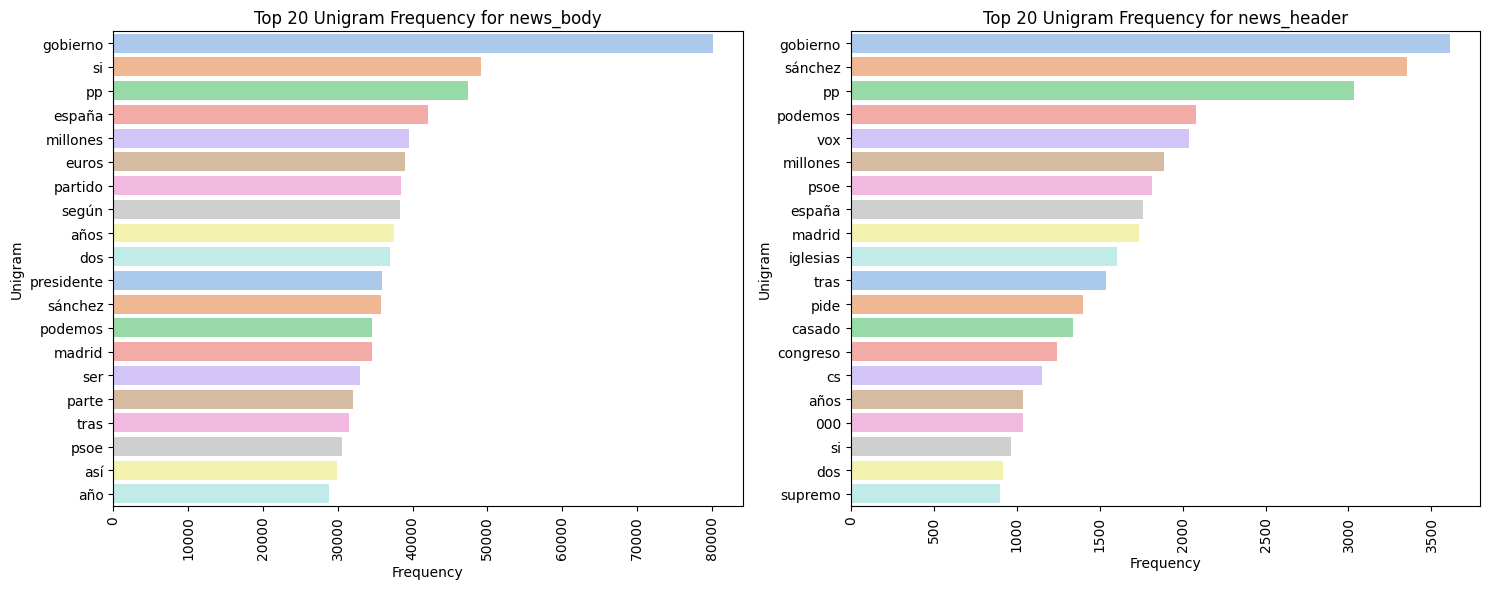

In [ ]:
plot_ngrams([unigram_freq_c, unigram_freq_r], ['news_body', 'news_header'], "Unigram")


Ahora vemos que multiples palabras si aparecen en ambas columnas, lo que nos da indicios que el dataset es congruente entre las noticias y los resumenes

/var/folders/ny/ynfjr6_16n5bnkj_51l0bkjr0000gn/T/ipykernel_39331/2638156123.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[i-1].head(20).values, y=data[i-1].head(20).index, orient='h', palette='pastel')
/var/folders/ny/ynfjr6_16n5bnkj_51l0bkjr0000gn/T/ipykernel_39331/2638156123.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[i-1].head(20).values, y=data[i-1].head(20).index, orient='h', palette='pastel')


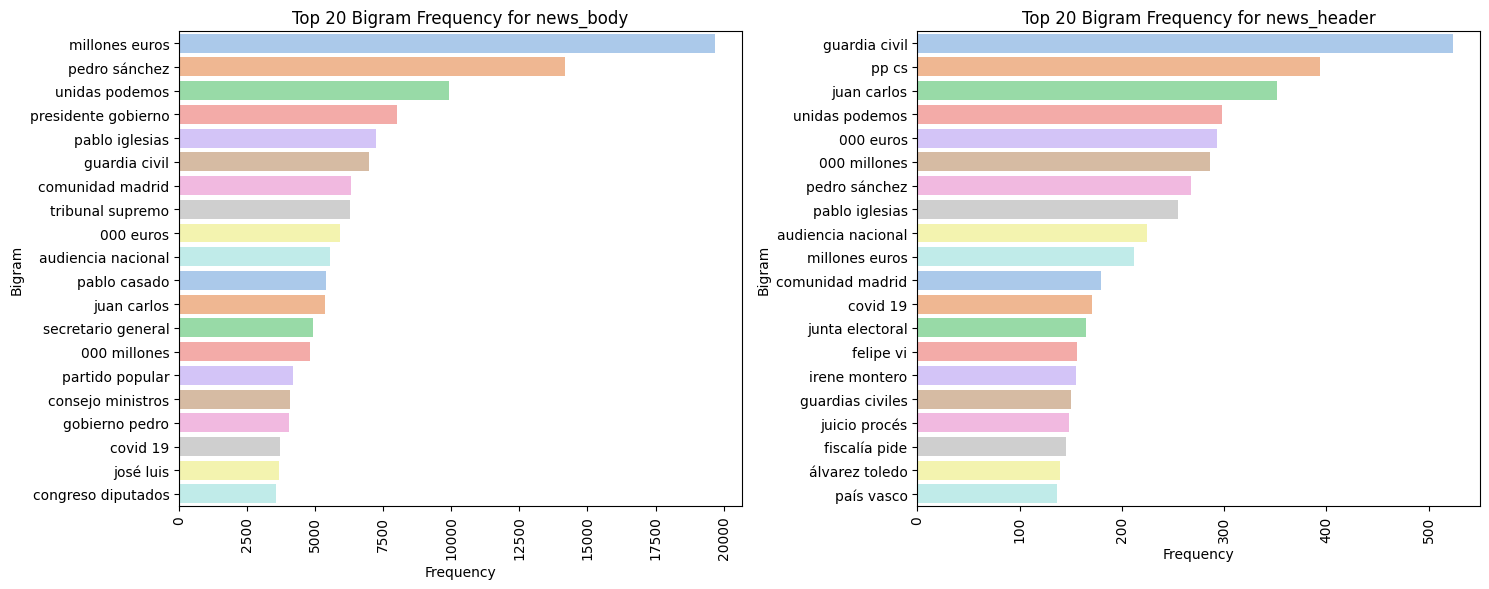

In [ ]:
plot_ngrams([bigram_freq_c, bigram_freq_r], ['news_body', 'news_header'], "Bigram")


Al revisar esta visualizacion tambien notamos congruencias entre palabras y temas que son abordados en las noticias

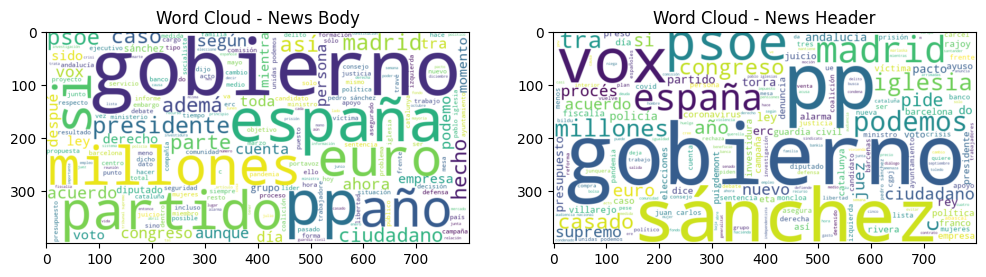

In [ ]:
context_txt = ' '.join(df['news_body'])
response_txt = ' '.join(df['news_header'])

wordcloud_context = WordCloud(width=800, stopwords=spanish_stopwords, height=400, background_color='white').generate(context_txt)
wordcloud_response = WordCloud(width=800, stopwords=spanish_stopwords, height=400, background_color='white').generate(response_txt)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_context, interpolation='bilinear')
plt.title('Word Cloud - News Body')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_response, interpolation='bilinear')
plt.title('Word Cloud - News Header')

plt.show()

Esta es otra represntacion de frecuencia en la que las palabras aparecen en el cuerpo de la noticia y en el resumen.

### Conclusiones:

#### Conclusion 1:

Dado que un modelo basado en transformer puede tener limitantes de tokens ej.(512, 1024), por lo que articulos demasiado grandes pueden causar problemas en un futuro o requerir truncamiento. Además dado que estos registros representan solo un 0.09% de los datos, no se tendra un impacto que preocupe, dado que 99.91% de la información se mantendra intacta.

#### Conclusion 2:
En términos generales, se aprecia una coherencia entre el contenido de las noticias y los encabezados, dado que los bigrams más frecuentes en el cuerpo (news_body) también aparecen, en gran medida, en los encabezados (news_header). Esto sugiere que los resúmenes (encabezados) capturan los temas principales de la noticia (principalmente asuntos políticos y económicos).